## Imports

In [1]:

from sklearn.metrics import  confusion_matrix
import spacy
import nltk
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, SelectPercentile
from sklearn.svm import SVR
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
random_seed = 42
from xgboost import XGBClassifier
tqdm.pandas()

/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## data

### read

In [2]:
df_features = pd.read_csv('../data/processed/processed_dataset.csv')
df_features

,corpus_name,id,parent,child,label,dep,parent_text,parent_lemma,parent_pos,parent_tag,...,child_lemma,child_pos,child_tag,child_shape,child_is_alpha,child_is_stop,child_morph,child_ner,child_ner_start_end,parent_ner_start_end
0,sci,1,ter,person,:ARG0,nsubj,tem,ter,VERB,VERB,...,Meyer,PROPN,PROPN,Xxxxx,True,False,Gender=Masc|Number=Sing,PER,"(0, 1)",NaN
1,sci,4,fazer,isso,:ARG1,nao_tem_dep,feito,fazer,VERB,VERB,...,isso,PRON,PRON,Xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
2,sci,4,fazer,universidade,:ARG3,obl,feito,fazer,VERB,VERB,...,universidade,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Sing,NaN,NaN,NaN
3,sci,12,acontecer,isso,:ARG1,nsubj,acontece,acontecer,VERB,VERB,...,isso,PRON,PRON,xxxx,True,True,Gender=Masc|Number=Sing|PronType=Dem,NaN,NaN,NaN
4,sci,16,entender,otimista,:ARG0,nsubj,entendem,entender,VERB,VERB,...,otimista,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Plur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065,news,poder-4-156,dizer,ter,:ARG1,ccomp,disse,dizer,VERB,VERB,...,ter,VERB,VERB,xxx,True,True,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbF...,NaN,NaN,NaN
3066,news,poder-4-156,ter,ponto,:ARG1,obj,tem,ter,VERB,VERB,...,ponto,NOUN,NOUN,xxxx,True,True,Gender=Masc|Number=Plur,NaN,NaN,NaN
3067,news,ilustrissima-4-167,utilizar,referência,:ARG1,obj,utilizar,utilizar,VERB,VERB,...,referência,NOUN,NOUN,xxxx,True,False,Gender=Fem|Number=Plur,NaN,NaN,NaN
3068,news,ciencia-4-171,chamar,fenômeno,:ARG1,obj,chamar,chamar,VERB,VERB,...,fenômeno,NOUN,NOUN,xxxx,True,False,Gender=Masc|Number=Sing,NaN,NaN,NaN


In [3]:
# dropa colunas inuteis
df_features = df_features.drop(['parent_shape',
       'parent_is_alpha', 'parent_is_stop', 'parent_morph', 'child_shape',
       'child_is_alpha', 'child_is_stop', 'child_morph', 
       'child_ner_start_end', 'parent_ner_start_end'],axis = 1)

df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner'],
      dtype='object')

In [4]:
df_features.isna().sum()

corpus_name        0
id                 0
parent             0
child              0
label              0
dep                0
parent_text        0
parent_lemma       0
parent_pos         0
parent_tag         0
parent_ner      3035
child_text         0
child_lemma        0
child_pos          0
child_tag          0
child_ner       3007
dtype: int64

In [5]:
### all nan to nsa (nao se aplica)
df_features.fillna('nsa', inplace = True)

In [6]:
df_features.label.value_counts()

label
:ARG1        1517
:ARG0        1033
:ARG2         296
:ARG1-of       95
:ARG0-of       63
:ARG3          37
:ARG4          23
:ARG2-of        5
:ARG01-of       1
Name: count, dtype: int64

In [7]:
# ################################
# # Completo 
# ################################

# df_features['label'] = df_features.label.apply(
#     lambda x: 
#         0 if "arg0" in x.casefold() else
#         1 if "arg1" in x.casefold() else
#         2 if "arg2" in x.casefold() else
#         3 if "arg3" in x.casefold() else
#         4 if "arg4" in x.casefold() else
#         5 if "arg5" in x.casefold() else
#         "erro"
        
# )

# df_features['label'].value_counts()

# df_features = df_features[
#     (df_features.label != 'erro') & (df_features.label != 5)]
# df_features.label.value_counts()

In [8]:
################################
# Só ARG0 e ARG1 
################################

df_features['label'] = df_features.label.apply(
    lambda x: 
        0 if "arg0" in x.casefold() else
        1 if "arg1" in x.casefold() else
        "erro"
        
)

df_features['label'].value_counts()

df_features = df_features[
    (df_features.label != 'erro')]
df_features.label.value_counts()

label
1    1612
0    1097
Name: count, dtype: int64

In [9]:
df_features.label = df_features.label.astype('int')

In [10]:
df_features['stratify-column'] = df_features.apply(lambda x: str(x.corpus_name) + "_" + str(x.label), axis = 1)
df_features['stratify-column']

0        sci_0
1        sci_1
3        sci_1
4        sci_0
5        sci_1
         ...  
3064    news_1
3065    news_1
3066    news_1
3067    news_1
3068    news_1
Name: stratify-column, Length: 2709, dtype: object

### split

In [11]:
df_features.columns

Index(['corpus_name', 'id', 'parent', 'child', 'label', 'dep', 'parent_text',
       'parent_lemma', 'parent_pos', 'parent_tag', 'parent_ner', 'child_text',
       'child_lemma', 'child_pos', 'child_tag', 'child_ner',
       'stratify-column'],
      dtype='object')

In [12]:
X = df_features.drop(['corpus_name', 'id', 'stratify-column', "label"], axis = 1)
y = df_features['label']

In [13]:
# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)z

In [14]:
len_emb= 50

model = KeyedVectors.load_word2vec_format(f'../embeddings/glove_s{len_emb}.txt')

In [15]:


# # Obter embeddings para as palavras em cada coluna
# def get_embedding(word):
    
#     # da pau quando nao tem a palavra
#     try:
#         return model[word]
#     except Exception as e:
#         return [-1000 for n in range(len_emb)] 

# embeddings_parent = X['parent_lemma'].progress_apply(get_embedding).tolist()
# X[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X.index)
# embeddings_child = X['child_lemma'].progress_apply(get_embedding).tolist()
# X[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X.index)

# X.drop(['parent', 'parent_lemma', 'child', 'child_lemma'], axis=1, inplace = True)

In [16]:
cat_cols = [col for col in X.columns if "emb" not in col]
X_enc = pd.get_dummies(X[cat_cols])
X_enc

,parent_abandonar,parent_abordar,parent_abrir,parent_acabar,parent_academia,parent_acender,parent_acessar,parent_achar,parent_aclamar,parent_acompanhar,...,child_tag_PRON,child_tag_PROPN,child_tag_PUNCT,child_tag_SCONJ,child_tag_VERB,child_ner_LOC,child_ner_MISC,child_ner_ORG,child_ner_PER,child_ner_nsa
0,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3066,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3067,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [17]:

# X_enc[[f"emb_{n}_child" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_child, index=X_enc.index)
# X_enc[[f"emb_{n}_parent" for n in range(1, len_emb + 1)]] = pd.DataFrame(embeddings_parent, index=X_enc.index)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify=df_features['stratify-column']
                                                    )

In [19]:
import scipy.stats as st

#selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)
selector = SelectPercentile()
sampler = SMOTE(random_state=random_seed)
scaler = StandardScaler(with_mean=False)

estimator = XGBClassifier(
    device = 'cuda',
#    tree_method = 'hist'
    )

pipeline_steps = [
    ('scaling', scaler),
    ('sampling', sampler),
    ('selecting', selector),
    ('estimator',estimator)
    ] 



pipeline = Pipeline(steps = pipeline_steps)


# Preconfigure estimator and parameters
params = {  
            "estimator__n_estimators": st.randint(3, 40),
            "estimator__max_depth": st.randint(3, 40),
            "estimator__learning_rate": st.uniform(0.05, 0.4),
            "estimator__colsample_bytree": st.beta(10, 1),
            "estimator__subsample": st.beta(10, 1),
            "estimator__gamma": st.uniform(0, 10),
           # 'estimator__objective': ['multi:softmax'],
            'estimator__eval_metric':['aucpr'],
            
#            'estimator__scale_pos_weight': st.randint(0, 2),
            "estimator__min_child_weight": st.expon(0, 50),
            "selecting__percentile": [10,25,40,50,80]
            
        }

# Random Search Training with 5 folds Cross Validation
rf_random = RandomizedSearchCV(
    pipeline, 
    params, 
    cv=5, 
    verbose=4,
    #n_jobs=-1, 
    n_iter=50, 
    #error_score = "raise",
    random_state=42, 
    scoring='f1_macro') 
                              
rf_random.fit(X_train, y_train)  
best_params = rf_random.best_params_
best_score = rf_random.best_score_

print('best_params', best_params)
print('best_score', best_score)

model = rf_random.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [23:22:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown 

[CV 1/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.770 total time=   1.1s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.758 total time=   1.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.802 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.771 total time=   1.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9252155845351104, estimator__eval_metric=aucpr, estimator__gamma=1.5601864044243652, estimator__learning_rate=0.11239780813448107, estimator__max_depth=13, estimator__min_child_weight=30.73980825409684, estimator__n_estimators=38, estimator__subsample=0.8977839979065437, selecting__percentile=80;, score=0.775 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.768 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.753 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.810 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.763 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9564706069253083, estimator__eval_metric=aucpr, estimator__gamma=5.247564316322379, estimator__learning_rate=0.22277800745684634, estimator__max_depth=29, estimator__min_child_weight=47.318543694989934, estimator__n_estimators=30, estimator__subsample=0.9684146437277473, selecting__percentile=40;, score=0.783 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.738 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.692 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.730 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.708 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8373057481974049, estimator__eval_metric=aucpr, estimator__gamma=6.803075385877797, estimator__learning_rate=0.2301997007878172, estimator__max_depth=20, estimator__min_child_weight=148.68438967534655, estimator__n_estimators=16, estimator__subsample=0.9633878958845166, selecting__percentile=80;, score=0.701 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.782 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.786 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.794 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.784 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8887171914136054, estimator__eval_metric=aucpr, estimator__gamma=8.331949117361644, estimator__learning_rate=0.11934586140310884, estimator__max_depth=19, estimator__min_child_weight=14.972888842034305, estimator__n_estimators=6, estimator__subsample=0.9102228078532095, selecting__percentile=25;, score=0.780 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.747 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.692 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.730 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.708 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9328708406636964, estimator__eval_metric=aucpr, estimator__gamma=3.9515023600181443, estimator__learning_rate=0.4206635463175177, estimator__max_depth=33, estimator__min_child_weight=127.47176896347025, estimator__n_estimators=10, estimator__subsample=0.9306661589622489, selecting__percentile=80;, score=0.701 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.752 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.751 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.767 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.746 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9288476205494544, estimator__eval_metric=aucpr, estimator__gamma=2.8093450968738076, estimator__learning_rate=0.2670784332632994, estimator__max_depth=31, estimator__min_child_weight=81.02417978873656, estimator__n_estimators=3, estimator__subsample=0.9324196351085577, selecting__percentile=10;, score=0.738 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.752 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.751 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.767 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.746 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.887104500494925, estimator__eval_metric=aucpr, estimator__gamma=0.7404465173409036, estimator__learning_rate=0.19338629141770908, estimator__max_depth=30, estimator__min_child_weight=99.42647858291113, estimator__n_estimators=10, estimator__subsample=0.9921649589831436, selecting__percentile=80;, score=0.738 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.780 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.775 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.793 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.765 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9510610451625398, estimator__eval_metric=aucpr, estimator__gamma=1.195942459383017, estimator__learning_rate=0.335297914889198, estimator__max_depth=3, estimator__min_child_weight=63.958084642302396, estimator__n_estimators=16, estimator__subsample=0.95154703001723, selecting__percentile=25;, score=0.789 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.776 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.737 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.793 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.765 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9332940236117113, estimator__eval_metric=aucpr, estimator__gamma=9.07566473926093, estimator__learning_rate=0.14971689165955, estimator__max_depth=17, estimator__min_child_weight=70.43745737692917, estimator__n_estimators=38, estimator__subsample=0.9056340402814923, selecting__percentile=40;, score=0.783 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.782 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.780 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.813 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.784 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8741814405114897, estimator__eval_metric=aucpr, estimator__gamma=1.8657005888603584, estimator__learning_rate=0.40702359939599114, estimator__max_depth=13, estimator__min_child_weight=19.603635966648525, estimator__n_estimators=30, estimator__subsample=0.8526493722244973, selecting__percentile=10;, score=0.772 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.785 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.758 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.800 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.766 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8117046387359118, estimator__eval_metric=aucpr, estimator__gamma=0.06952130531190703, estimator__learning_rate=0.2542989210310263, estimator__max_depth=11, estimator__min_child_weight=33.16291400529039, estimator__n_estimators=35, estimator__subsample=0.9336160224397914, selecting__percentile=40;, score=0.785 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.778 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.744 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.787 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.759 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9581599272512872, estimator__eval_metric=aucpr, estimator__gamma=9.717820827209607, estimator__learning_rate=0.4349789179768445, estimator__max_depth=4, estimator__min_child_weight=62.28673944235778, estimator__n_estimators=39, estimator__subsample=0.9919714387133912, selecting__percentile=10;, score=0.789 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.519 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.517 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.558 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.578 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9572112088939196, estimator__eval_metric=aucpr, estimator__gamma=6.343513447013638, estimator__learning_rate=0.3222821806219067, estimator__max_depth=28, estimator__min_child_weight=212.20184913076298, estimator__n_estimators=34, estimator__subsample=0.9922391623967441, selecting__percentile=40;, score=0.519 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.752 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.751 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.767 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.746 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.747093280352113, estimator__eval_metric=aucpr, estimator__gamma=3.9882444244455306, estimator__learning_rate=0.3765727492877536, estimator__max_depth=18, estimator__min_child_weight=90.18223971231485, estimator__n_estimators=8, estimator__subsample=0.8009976624475645, selecting__percentile=50;, score=0.738 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.752 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.751 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.793 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.765 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9669315169009046, estimator__eval_metric=aucpr, estimator__gamma=6.90937738102466, estimator__learning_rate=0.20469413852021495, estimator__max_depth=20, estimator__min_child_weight=90.91855366176486, estimator__n_estimators=13, estimator__subsample=0.9879578025582105, selecting__percentile=25;, score=0.738 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.759 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.753 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.810 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.761 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.938780053153158, estimator__eval_metric=aucpr, estimator__gamma=5.296505783560065, estimator__learning_rate=0.14674091636018066, estimator__max_depth=14, estimator__min_child_weight=40.85547697931888, estimator__n_estimators=34, estimator__subsample=0.9385377204344674, selecting__percentile=40;, score=0.765 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.780 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.781 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.793 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.765 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9599749174776359, estimator__eval_metric=aucpr, estimator__gamma=8.877700987609598, estimator__learning_rate=0.3903713795070051, estimator__max_depth=10, estimator__min_child_weight=76.93514655835237, estimator__n_estimators=22, estimator__subsample=0.9601120826418095, selecting__percentile=10;, score=0.789 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.782 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.782 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.799 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.771 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9063987912575674, estimator__eval_metric=aucpr, estimator__gamma=2.242693094605598, estimator__learning_rate=0.33487168853901433, estimator__max_depth=35, estimator__min_child_weight=34.05042913536439, estimator__n_estimators=22, estimator__subsample=0.8233835331847403, selecting__percentile=40;, score=0.766 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.768 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.783 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.789 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.761 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9644992169134261, estimator__eval_metric=aucpr, estimator__gamma=2.6520236768172545, estimator__learning_rate=0.14759585735163344, estimator__max_depth=10, estimator__min_child_weight=49.86671928682416, estimator__n_estimators=36, estimator__subsample=0.942063880043645, selecting__percentile=10;, score=0.791 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.804 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.781 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.793 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.765 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9979085342494173, estimator__eval_metric=aucpr, estimator__gamma=6.454722959071678, estimator__learning_rate=0.12084427176281959, estimator__max_depth=30, estimator__min_child_weight=31.738679366625984, estimator__n_estimators=8, estimator__subsample=0.9978527781533681, selecting__percentile=80;, score=0.769 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8539837143495722, estimator__eval_metric=aucpr, estimator__gamma=2.944488920695857, estimator__learning_rate=0.2040390914407701, estimator__max_depth=25, estimator__min_child_weight=15.631184356190609, estimator__n_estimators=5, estimator__subsample=0.9206554022694008, selecting__percentile=25;, score=0.788 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8539837143495722, estimator__eval_metric=aucpr, estimator__gamma=2.944488920695857, estimator__learning_rate=0.2040390914407701, estimator__max_depth=25, estimator__min_child_weight=15.631184356190609, estimator__n_estimators=5, estimator__subsample=0.9206554022694008, selecting__percentile=25;, score=0.784 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8539837143495722, estimator__eval_metric=aucpr, estimator__gamma=2.944488920695857, estimator__learning_rate=0.2040390914407701, estimator__max_depth=25, estimator__min_child_weight=15.631184356190609, estimator__n_estimators=5, estimator__subsample=0.9206554022694008, selecting__percentile=25;, score=0.797 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8539837143495722, estimator__eval_metric=aucpr, estimator__gamma=2.944488920695857, estimator__learning_rate=0.2040390914407701, estimator__max_depth=25, estimator__min_child_weight=15.631184356190609, estimator__n_estimators=5, estimator__subsample=0.9206554022694008, selecting__percentile=25;, score=0.784 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8539837143495722, estimator__eval_metric=aucpr, estimator__gamma=2.944488920695857, estimator__learning_rate=0.2040390914407701, estimator__max_depth=25, estimator__min_child_weight=15.631184356190609, estimator__n_estimators=5, estimator__subsample=0.9206554022694008, selecting__percentile=25;, score=0.785 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9757084655381856, estimator__eval_metric=aucpr, estimator__gamma=2.9529058841893874, estimator__learning_rate=0.1790203056954402, estimator__max_depth=35, estimator__min_child_weight=7.3450951246076, estimator__n_estimators=31, estimator__subsample=0.9246727968371935, selecting__percentile=25;, score=0.801 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9757084655381856, estimator__eval_metric=aucpr, estimator__gamma=2.9529058841893874, estimator__learning_rate=0.1790203056954402, estimator__max_depth=35, estimator__min_child_weight=7.3450951246076, estimator__n_estimators=31, estimator__subsample=0.9246727968371935, selecting__percentile=25;, score=0.801 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9757084655381856, estimator__eval_metric=aucpr, estimator__gamma=2.9529058841893874, estimator__learning_rate=0.1790203056954402, estimator__max_depth=35, estimator__min_child_weight=7.3450951246076, estimator__n_estimators=31, estimator__subsample=0.9246727968371935, selecting__percentile=25;, score=0.833 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9757084655381856, estimator__eval_metric=aucpr, estimator__gamma=2.9529058841893874, estimator__learning_rate=0.1790203056954402, estimator__max_depth=35, estimator__min_child_weight=7.3450951246076, estimator__n_estimators=31, estimator__subsample=0.9246727968371935, selecting__percentile=25;, score=0.809 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9757084655381856, estimator__eval_metric=aucpr, estimator__gamma=2.9529058841893874, estimator__learning_rate=0.1790203056954402, estimator__max_depth=35, estimator__min_child_weight=7.3450951246076, estimator__n_estimators=31, estimator__subsample=0.9246727968371935, selecting__percentile=25;, score=0.805 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9153983599498906, estimator__eval_metric=aucpr, estimator__gamma=7.019668772577034, estimator__learning_rate=0.36831706777444045, estimator__max_depth=14, estimator__min_child_weight=108.84925622193238, estimator__n_estimators=17, estimator__subsample=0.9963944129497636, selecting__percentile=40;, score=0.752 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9153983599498906, estimator__eval_metric=aucpr, estimator__gamma=7.019668772577034, estimator__learning_rate=0.36831706777444045, estimator__max_depth=14, estimator__min_child_weight=108.84925622193238, estimator__n_estimators=17, estimator__subsample=0.9963944129497636, selecting__percentile=40;, score=0.751 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9153983599498906, estimator__eval_metric=aucpr, estimator__gamma=7.019668772577034, estimator__learning_rate=0.36831706777444045, estimator__max_depth=14, estimator__min_child_weight=108.84925622193238, estimator__n_estimators=17, estimator__subsample=0.9963944129497636, selecting__percentile=40;, score=0.787 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9153983599498906, estimator__eval_metric=aucpr, estimator__gamma=7.019668772577034, estimator__learning_rate=0.36831706777444045, estimator__max_depth=14, estimator__min_child_weight=108.84925622193238, estimator__n_estimators=17, estimator__subsample=0.9963944129497636, selecting__percentile=40;, score=0.746 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9153983599498906, estimator__eval_metric=aucpr, estimator__gamma=7.019668772577034, estimator__learning_rate=0.36831706777444045, estimator__max_depth=14, estimator__min_child_weight=108.84925622193238, estimator__n_estimators=17, estimator__subsample=0.9963944129497636, selecting__percentile=40;, score=0.789 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9546159951077549, estimator__eval_metric=aucpr, estimator__gamma=0.3050024993904943, estimator__learning_rate=0.06493927549968577, estimator__max_depth=8, estimator__min_child_weight=18.06754400351632, estimator__n_estimators=39, estimator__subsample=0.7709195053225008, selecting__percentile=50;, score=0.798 total time=   1.0s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9546159951077549, estimator__eval_metric=aucpr, estimator__gamma=0.3050024993904943, estimator__learning_rate=0.06493927549968577, estimator__max_depth=8, estimator__min_child_weight=18.06754400351632, estimator__n_estimators=39, estimator__subsample=0.7709195053225008, selecting__percentile=50;, score=0.784 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9546159951077549, estimator__eval_metric=aucpr, estimator__gamma=0.3050024993904943, estimator__learning_rate=0.06493927549968577, estimator__max_depth=8, estimator__min_child_weight=18.06754400351632, estimator__n_estimators=39, estimator__subsample=0.7709195053225008, selecting__percentile=50;, score=0.801 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9546159951077549, estimator__eval_metric=aucpr, estimator__gamma=0.3050024993904943, estimator__learning_rate=0.06493927549968577, estimator__max_depth=8, estimator__min_child_weight=18.06754400351632, estimator__n_estimators=39, estimator__subsample=0.7709195053225008, selecting__percentile=50;, score=0.786 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9546159951077549, estimator__eval_metric=aucpr, estimator__gamma=0.3050024993904943, estimator__learning_rate=0.06493927549968577, estimator__max_depth=8, estimator__min_child_weight=18.06754400351632, estimator__n_estimators=39, estimator__subsample=0.7709195053225008, selecting__percentile=50;, score=0.792 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9777983051527802, estimator__eval_metric=aucpr, estimator__gamma=4.113539050566786, estimator__learning_rate=0.32980488430687754, estimator__max_depth=18, estimator__min_child_weight=186.17785043499964, estimator__n_estimators=32, estimator__subsample=0.9571648768836749, selecting__percentile=40;, score=0.519 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9777983051527802, estimator__eval_metric=aucpr, estimator__gamma=4.113539050566786, estimator__learning_rate=0.32980488430687754, estimator__max_depth=18, estimator__min_child_weight=186.17785043499964, estimator__n_estimators=32, estimator__subsample=0.9571648768836749, selecting__percentile=40;, score=0.517 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9777983051527802, estimator__eval_metric=aucpr, estimator__gamma=4.113539050566786, estimator__learning_rate=0.32980488430687754, estimator__max_depth=18, estimator__min_child_weight=186.17785043499964, estimator__n_estimators=32, estimator__subsample=0.9571648768836749, selecting__percentile=40;, score=0.558 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9777983051527802, estimator__eval_metric=aucpr, estimator__gamma=4.113539050566786, estimator__learning_rate=0.32980488430687754, estimator__max_depth=18, estimator__min_child_weight=186.17785043499964, estimator__n_estimators=32, estimator__subsample=0.9571648768836749, selecting__percentile=40;, score=0.578 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9777983051527802, estimator__eval_metric=aucpr, estimator__gamma=4.113539050566786, estimator__learning_rate=0.32980488430687754, estimator__max_depth=18, estimator__min_child_weight=186.17785043499964, estimator__n_estimators=32, estimator__subsample=0.9571648768836749, selecting__percentile=40;, score=0.519 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.6925795517077962, estimator__eval_metric=aucpr, estimator__gamma=8.359801205122059, estimator__learning_rate=0.3283896824374792, estimator__max_depth=3, estimator__min_child_weight=9.515326807105437, estimator__n_estimators=3, estimator__subsample=0.971407610304963, selecting__percentile=10;, score=0.773 total time=   0.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.6925795517077962, estimator__eval_metric=aucpr, estimator__gamma=8.359801205122059, estimator__learning_rate=0.3283896824374792, estimator__max_depth=3, estimator__min_child_weight=9.515326807105437, estimator__n_estimators=3, estimator__subsample=0.971407610304963, selecting__percentile=10;, score=0.782 total time=   0.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.6925795517077962, estimator__eval_metric=aucpr, estimator__gamma=8.359801205122059, estimator__learning_rate=0.3283896824374792, estimator__max_depth=3, estimator__min_child_weight=9.515326807105437, estimator__n_estimators=3, estimator__subsample=0.971407610304963, selecting__percentile=10;, score=0.842 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.6925795517077962, estimator__eval_metric=aucpr, estimator__gamma=8.359801205122059, estimator__learning_rate=0.3283896824374792, estimator__max_depth=3, estimator__min_child_weight=9.515326807105437, estimator__n_estimators=3, estimator__subsample=0.971407610304963, selecting__percentile=10;, score=0.779 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.6925795517077962, estimator__eval_metric=aucpr, estimator__gamma=8.359801205122059, estimator__learning_rate=0.3283896824374792, estimator__max_depth=3, estimator__min_child_weight=9.515326807105437, estimator__n_estimators=3, estimator__subsample=0.971407610304963, selecting__percentile=10;, score=0.774 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8236162265519251, estimator__eval_metric=aucpr, estimator__gamma=5.543540525114007, estimator__learning_rate=0.2946882984937409, estimator__max_depth=5, estimator__min_child_weight=14.233064613703176, estimator__n_estimators=18, estimator__subsample=0.9901054390835515, selecting__percentile=80;, score=0.800 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8236162265519251, estimator__eval_metric=aucpr, estimator__gamma=5.543540525114007, estimator__learning_rate=0.2946882984937409, estimator__max_depth=5, estimator__min_child_weight=14.233064613703176, estimator__n_estimators=18, estimator__subsample=0.9901054390835515, selecting__percentile=80;, score=0.798 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8236162265519251, estimator__eval_metric=aucpr, estimator__gamma=5.543540525114007, estimator__learning_rate=0.2946882984937409, estimator__max_depth=5, estimator__min_child_weight=14.233064613703176, estimator__n_estimators=18, estimator__subsample=0.9901054390835515, selecting__percentile=80;, score=0.837 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8236162265519251, estimator__eval_metric=aucpr, estimator__gamma=5.543540525114007, estimator__learning_rate=0.2946882984937409, estimator__max_depth=5, estimator__min_child_weight=14.233064613703176, estimator__n_estimators=18, estimator__subsample=0.9901054390835515, selecting__percentile=80;, score=0.807 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8236162265519251, estimator__eval_metric=aucpr, estimator__gamma=5.543540525114007, estimator__learning_rate=0.2946882984937409, estimator__max_depth=5, estimator__min_child_weight=14.233064613703176, estimator__n_estimators=18, estimator__subsample=0.9901054390835515, selecting__percentile=80;, score=0.786 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9297031337096454, estimator__eval_metric=aucpr, estimator__gamma=4.734717707805657, estimator__learning_rate=0.11928074796400608, estimator__max_depth=32, estimator__min_child_weight=52.4587856223648, estimator__n_estimators=12, estimator__subsample=0.8848518534146546, selecting__percentile=50;, score=0.776 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9297031337096454, estimator__eval_metric=aucpr, estimator__gamma=4.734717707805657, estimator__learning_rate=0.11928074796400608, estimator__max_depth=32, estimator__min_child_weight=52.4587856223648, estimator__n_estimators=12, estimator__subsample=0.8848518534146546, selecting__percentile=50;, score=0.764 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9297031337096454, estimator__eval_metric=aucpr, estimator__gamma=4.734717707805657, estimator__learning_rate=0.11928074796400608, estimator__max_depth=32, estimator__min_child_weight=52.4587856223648, estimator__n_estimators=12, estimator__subsample=0.8848518534146546, selecting__percentile=50;, score=0.770 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9297031337096454, estimator__eval_metric=aucpr, estimator__gamma=4.734717707805657, estimator__learning_rate=0.11928074796400608, estimator__max_depth=32, estimator__min_child_weight=52.4587856223648, estimator__n_estimators=12, estimator__subsample=0.8848518534146546, selecting__percentile=50;, score=0.756 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9297031337096454, estimator__eval_metric=aucpr, estimator__gamma=4.734717707805657, estimator__learning_rate=0.11928074796400608, estimator__max_depth=32, estimator__min_child_weight=52.4587856223648, estimator__n_estimators=12, estimator__subsample=0.8848518534146546, selecting__percentile=50;, score=0.789 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8845617015841987, estimator__eval_metric=aucpr, estimator__gamma=6.58693631618945, estimator__learning_rate=0.11517377083257188, estimator__max_depth=26, estimator__min_child_weight=144.02349131633633, estimator__n_estimators=4, estimator__subsample=0.8691529363212154, selecting__percentile=40;, score=0.738 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8845617015841987, estimator__eval_metric=aucpr, estimator__gamma=6.58693631618945, estimator__learning_rate=0.11517377083257188, estimator__max_depth=26, estimator__min_child_weight=144.02349131633633, estimator__n_estimators=4, estimator__subsample=0.8691529363212154, selecting__percentile=40;, score=0.692 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8845617015841987, estimator__eval_metric=aucpr, estimator__gamma=6.58693631618945, estimator__learning_rate=0.11517377083257188, estimator__max_depth=26, estimator__min_child_weight=144.02349131633633, estimator__n_estimators=4, estimator__subsample=0.8691529363212154, selecting__percentile=40;, score=0.730 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8845617015841987, estimator__eval_metric=aucpr, estimator__gamma=6.58693631618945, estimator__learning_rate=0.11517377083257188, estimator__max_depth=26, estimator__min_child_weight=144.02349131633633, estimator__n_estimators=4, estimator__subsample=0.8691529363212154, selecting__percentile=40;, score=0.708 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8845617015841987, estimator__eval_metric=aucpr, estimator__gamma=6.58693631618945, estimator__learning_rate=0.11517377083257188, estimator__max_depth=26, estimator__min_child_weight=144.02349131633633, estimator__n_estimators=4, estimator__subsample=0.8691529363212154, selecting__percentile=40;, score=0.701 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9883636917110922, estimator__eval_metric=aucpr, estimator__gamma=8.11204176736003, estimator__learning_rate=0.37825579029758216, estimator__max_depth=14, estimator__min_child_weight=24.396376367509358, estimator__n_estimators=35, estimator__subsample=0.9828199118871436, selecting__percentile=80;, score=0.795 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9883636917110922, estimator__eval_metric=aucpr, estimator__gamma=8.11204176736003, estimator__learning_rate=0.37825579029758216, estimator__max_depth=14, estimator__min_child_weight=24.396376367509358, estimator__n_estimators=35, estimator__subsample=0.9828199118871436, selecting__percentile=80;, score=0.782 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9883636917110922, estimator__eval_metric=aucpr, estimator__gamma=8.11204176736003, estimator__learning_rate=0.37825579029758216, estimator__max_depth=14, estimator__min_child_weight=24.396376367509358, estimator__n_estimators=35, estimator__subsample=0.9828199118871436, selecting__percentile=80;, score=0.816 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9883636917110922, estimator__eval_metric=aucpr, estimator__gamma=8.11204176736003, estimator__learning_rate=0.37825579029758216, estimator__max_depth=14, estimator__min_child_weight=24.396376367509358, estimator__n_estimators=35, estimator__subsample=0.9828199118871436, selecting__percentile=80;, score=0.786 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9883636917110922, estimator__eval_metric=aucpr, estimator__gamma=8.11204176736003, estimator__learning_rate=0.37825579029758216, estimator__max_depth=14, estimator__min_child_weight=24.396376367509358, estimator__n_estimators=35, estimator__subsample=0.9828199118871436, selecting__percentile=80;, score=0.789 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8154068083999978, estimator__eval_metric=aucpr, estimator__gamma=0.23271935735825866, estimator__learning_rate=0.37578739303557435, estimator__max_depth=9, estimator__min_child_weight=6.287505991455382, estimator__n_estimators=13, estimator__subsample=0.8860311404445035, selecting__percentile=80;, score=0.800 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8154068083999978, estimator__eval_metric=aucpr, estimator__gamma=0.23271935735825866, estimator__learning_rate=0.37578739303557435, estimator__max_depth=9, estimator__min_child_weight=6.287505991455382, estimator__n_estimators=13, estimator__subsample=0.8860311404445035, selecting__percentile=80;, score=0.808 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8154068083999978, estimator__eval_metric=aucpr, estimator__gamma=0.23271935735825866, estimator__learning_rate=0.37578739303557435, estimator__max_depth=9, estimator__min_child_weight=6.287505991455382, estimator__n_estimators=13, estimator__subsample=0.8860311404445035, selecting__percentile=80;, score=0.829 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8154068083999978, estimator__eval_metric=aucpr, estimator__gamma=0.23271935735825866, estimator__learning_rate=0.37578739303557435, estimator__max_depth=9, estimator__min_child_weight=6.287505991455382, estimator__n_estimators=13, estimator__subsample=0.8860311404445035, selecting__percentile=80;, score=0.804 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8154068083999978, estimator__eval_metric=aucpr, estimator__gamma=0.23271935735825866, estimator__learning_rate=0.37578739303557435, estimator__max_depth=9, estimator__min_child_weight=6.287505991455382, estimator__n_estimators=13, estimator__subsample=0.8860311404445035, selecting__percentile=80;, score=0.783 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9211936884219791, estimator__eval_metric=aucpr, estimator__gamma=5.759245752580846, estimator__learning_rate=0.34265910211985606, estimator__max_depth=38, estimator__min_child_weight=23.262195598086635, estimator__n_estimators=34, estimator__subsample=0.808695971991611, selecting__percentile=80;, score=0.793 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9211936884219791, estimator__eval_metric=aucpr, estimator__gamma=5.759245752580846, estimator__learning_rate=0.34265910211985606, estimator__max_depth=38, estimator__min_child_weight=23.262195598086635, estimator__n_estimators=34, estimator__subsample=0.808695971991611, selecting__percentile=80;, score=0.783 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9211936884219791, estimator__eval_metric=aucpr, estimator__gamma=5.759245752580846, estimator__learning_rate=0.34265910211985606, estimator__max_depth=38, estimator__min_child_weight=23.262195598086635, estimator__n_estimators=34, estimator__subsample=0.808695971991611, selecting__percentile=80;, score=0.819 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9211936884219791, estimator__eval_metric=aucpr, estimator__gamma=5.759245752580846, estimator__learning_rate=0.34265910211985606, estimator__max_depth=38, estimator__min_child_weight=23.262195598086635, estimator__n_estimators=34, estimator__subsample=0.808695971991611, selecting__percentile=80;, score=0.786 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9211936884219791, estimator__eval_metric=aucpr, estimator__gamma=5.759245752580846, estimator__learning_rate=0.34265910211985606, estimator__max_depth=38, estimator__min_child_weight=23.262195598086635, estimator__n_estimators=34, estimator__subsample=0.808695971991611, selecting__percentile=80;, score=0.779 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.978257945587561, estimator__eval_metric=aucpr, estimator__gamma=3.7772888617629485, estimator__learning_rate=0.2637309894122254, estimator__max_depth=22, estimator__min_child_weight=87.5666278761665, estimator__n_estimators=24, estimator__subsample=0.9843062894618764, selecting__percentile=50;, score=0.752 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.978257945587561, estimator__eval_metric=aucpr, estimator__gamma=3.7772888617629485, estimator__learning_rate=0.2637309894122254, estimator__max_depth=22, estimator__min_child_weight=87.5666278761665, estimator__n_estimators=24, estimator__subsample=0.9843062894618764, selecting__percentile=50;, score=0.751 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.978257945587561, estimator__eval_metric=aucpr, estimator__gamma=3.7772888617629485, estimator__learning_rate=0.2637309894122254, estimator__max_depth=22, estimator__min_child_weight=87.5666278761665, estimator__n_estimators=24, estimator__subsample=0.9843062894618764, selecting__percentile=50;, score=0.767 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.978257945587561, estimator__eval_metric=aucpr, estimator__gamma=3.7772888617629485, estimator__learning_rate=0.2637309894122254, estimator__max_depth=22, estimator__min_child_weight=87.5666278761665, estimator__n_estimators=24, estimator__subsample=0.9843062894618764, selecting__percentile=50;, score=0.746 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.978257945587561, estimator__eval_metric=aucpr, estimator__gamma=3.7772888617629485, estimator__learning_rate=0.2637309894122254, estimator__max_depth=22, estimator__min_child_weight=87.5666278761665, estimator__n_estimators=24, estimator__subsample=0.9843062894618764, selecting__percentile=50;, score=0.738 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.7462966417375859, estimator__eval_metric=aucpr, estimator__gamma=5.734378881232861, estimator__learning_rate=0.3027348848679197, estimator__max_depth=7, estimator__min_child_weight=17.35113893730985, estimator__n_estimators=27, estimator__subsample=0.9705521808422148, selecting__percentile=80;, score=0.800 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.7462966417375859, estimator__eval_metric=aucpr, estimator__gamma=5.734378881232861, estimator__learning_rate=0.3027348848679197, estimator__max_depth=7, estimator__min_child_weight=17.35113893730985, estimator__n_estimators=27, estimator__subsample=0.9705521808422148, selecting__percentile=80;, score=0.798 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.7462966417375859, estimator__eval_metric=aucpr, estimator__gamma=5.734378881232861, estimator__learning_rate=0.3027348848679197, estimator__max_depth=7, estimator__min_child_weight=17.35113893730985, estimator__n_estimators=27, estimator__subsample=0.9705521808422148, selecting__percentile=80;, score=0.841 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.7462966417375859, estimator__eval_metric=aucpr, estimator__gamma=5.734378881232861, estimator__learning_rate=0.3027348848679197, estimator__max_depth=7, estimator__min_child_weight=17.35113893730985, estimator__n_estimators=27, estimator__subsample=0.9705521808422148, selecting__percentile=80;, score=0.805 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.7462966417375859, estimator__eval_metric=aucpr, estimator__gamma=5.734378881232861, estimator__learning_rate=0.3027348848679197, estimator__max_depth=7, estimator__min_child_weight=17.35113893730985, estimator__n_estimators=27, estimator__subsample=0.9705521808422148, selecting__percentile=80;, score=0.781 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9450930682166423, estimator__eval_metric=aucpr, estimator__gamma=0.5755876001664428, estimator__learning_rate=0.2698115529294942, estimator__max_depth=7, estimator__min_child_weight=66.78682264341442, estimator__n_estimators=31, estimator__subsample=0.9895191161427362, selecting__percentile=50;, score=0.780 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9450930682166423, estimator__eval_metric=aucpr, estimator__gamma=0.5755876001664428, estimator__learning_rate=0.2698115529294942, estimator__max_depth=7, estimator__min_child_weight=66.78682264341442, estimator__n_estimators=31, estimator__subsample=0.9895191161427362, selecting__percentile=50;, score=0.781 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9450930682166423, estimator__eval_metric=aucpr, estimator__gamma=0.5755876001664428, estimator__learning_rate=0.2698115529294942, estimator__max_depth=7, estimator__min_child_weight=66.78682264341442, estimator__n_estimators=31, estimator__subsample=0.9895191161427362, selecting__percentile=50;, score=0.793 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9450930682166423, estimator__eval_metric=aucpr, estimator__gamma=0.5755876001664428, estimator__learning_rate=0.2698115529294942, estimator__max_depth=7, estimator__min_child_weight=66.78682264341442, estimator__n_estimators=31, estimator__subsample=0.9895191161427362, selecting__percentile=50;, score=0.765 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9450930682166423, estimator__eval_metric=aucpr, estimator__gamma=0.5755876001664428, estimator__learning_rate=0.2698115529294942, estimator__max_depth=7, estimator__min_child_weight=66.78682264341442, estimator__n_estimators=31, estimator__subsample=0.9895191161427362, selecting__percentile=50;, score=0.789 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8744880927802564, estimator__eval_metric=aucpr, estimator__gamma=4.260914750469411, estimator__learning_rate=0.1390305670284122, estimator__max_depth=11, estimator__min_child_weight=86.25929269042906, estimator__n_estimators=4, estimator__subsample=0.9922104495676606, selecting__percentile=40;, score=0.793 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8744880927802564, estimator__eval_metric=aucpr, estimator__gamma=4.260914750469411, estimator__learning_rate=0.1390305670284122, estimator__max_depth=11, estimator__min_child_weight=86.25929269042906, estimator__n_estimators=4, estimator__subsample=0.9922104495676606, selecting__percentile=40;, score=0.751 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8744880927802564, estimator__eval_metric=aucpr, estimator__gamma=4.260914750469411, estimator__learning_rate=0.1390305670284122, estimator__max_depth=11, estimator__min_child_weight=86.25929269042906, estimator__n_estimators=4, estimator__subsample=0.9922104495676606, selecting__percentile=40;, score=0.787 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8744880927802564, estimator__eval_metric=aucpr, estimator__gamma=4.260914750469411, estimator__learning_rate=0.1390305670284122, estimator__max_depth=11, estimator__min_child_weight=86.25929269042906, estimator__n_estimators=4, estimator__subsample=0.9922104495676606, selecting__percentile=40;, score=0.746 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8744880927802564, estimator__eval_metric=aucpr, estimator__gamma=4.260914750469411, estimator__learning_rate=0.1390305670284122, estimator__max_depth=11, estimator__min_child_weight=86.25929269042906, estimator__n_estimators=4, estimator__subsample=0.9922104495676606, selecting__percentile=40;, score=0.789 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9801755449879475, estimator__eval_metric=aucpr, estimator__gamma=9.076937063485463, estimator__learning_rate=0.28675549552851376, estimator__max_depth=38, estimator__min_child_weight=23.601049980956283, estimator__n_estimators=33, estimator__subsample=0.9564359795554633, selecting__percentile=40;, score=0.797 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9801755449879475, estimator__eval_metric=aucpr, estimator__gamma=9.076937063485463, estimator__learning_rate=0.28675549552851376, estimator__max_depth=38, estimator__min_child_weight=23.601049980956283, estimator__n_estimators=33, estimator__subsample=0.9564359795554633, selecting__percentile=40;, score=0.779 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9801755449879475, estimator__eval_metric=aucpr, estimator__gamma=9.076937063485463, estimator__learning_rate=0.28675549552851376, estimator__max_depth=38, estimator__min_child_weight=23.601049980956283, estimator__n_estimators=33, estimator__subsample=0.9564359795554633, selecting__percentile=40;, score=0.822 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9801755449879475, estimator__eval_metric=aucpr, estimator__gamma=9.076937063485463, estimator__learning_rate=0.28675549552851376, estimator__max_depth=38, estimator__min_child_weight=23.601049980956283, estimator__n_estimators=33, estimator__subsample=0.9564359795554633, selecting__percentile=40;, score=0.799 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9801755449879475, estimator__eval_metric=aucpr, estimator__gamma=9.076937063485463, estimator__learning_rate=0.28675549552851376, estimator__max_depth=38, estimator__min_child_weight=23.601049980956283, estimator__n_estimators=33, estimator__subsample=0.9564359795554633, selecting__percentile=40;, score=0.789 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9620031743407316, estimator__eval_metric=aucpr, estimator__gamma=4.052020867814171, estimator__learning_rate=0.27858921008200427, estimator__max_depth=22, estimator__min_child_weight=6.324549796558561, estimator__n_estimators=3, estimator__subsample=0.9597245654892131, selecting__percentile=10;, score=0.802 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9620031743407316, estimator__eval_metric=aucpr, estimator__gamma=4.052020867814171, estimator__learning_rate=0.27858921008200427, estimator__max_depth=22, estimator__min_child_weight=6.324549796558561, estimator__n_estimators=3, estimator__subsample=0.9597245654892131, selecting__percentile=10;, score=0.786 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9620031743407316, estimator__eval_metric=aucpr, estimator__gamma=4.052020867814171, estimator__learning_rate=0.27858921008200427, estimator__max_depth=22, estimator__min_child_weight=6.324549796558561, estimator__n_estimators=3, estimator__subsample=0.9597245654892131, selecting__percentile=10;, score=0.826 total time=   0.4s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9620031743407316, estimator__eval_metric=aucpr, estimator__gamma=4.052020867814171, estimator__learning_rate=0.27858921008200427, estimator__max_depth=22, estimator__min_child_weight=6.324549796558561, estimator__n_estimators=3, estimator__subsample=0.9597245654892131, selecting__percentile=10;, score=0.793 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9620031743407316, estimator__eval_metric=aucpr, estimator__gamma=4.052020867814171, estimator__learning_rate=0.27858921008200427, estimator__max_depth=22, estimator__min_child_weight=6.324549796558561, estimator__n_estimators=3, estimator__subsample=0.9597245654892131, selecting__percentile=10;, score=0.778 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9584141478239542, estimator__eval_metric=aucpr, estimator__gamma=9.632225394406113, estimator__learning_rate=0.05486178987592654, estimator__max_depth=34, estimator__min_child_weight=40.597103245420705, estimator__n_estimators=23, estimator__subsample=0.7377238729679196, selecting__percentile=50;, score=0.774 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9584141478239542, estimator__eval_metric=aucpr, estimator__gamma=9.632225394406113, estimator__learning_rate=0.05486178987592654, estimator__max_depth=34, estimator__min_child_weight=40.597103245420705, estimator__n_estimators=23, estimator__subsample=0.7377238729679196, selecting__percentile=50;, score=0.768 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9584141478239542, estimator__eval_metric=aucpr, estimator__gamma=9.632225394406113, estimator__learning_rate=0.05486178987592654, estimator__max_depth=34, estimator__min_child_weight=40.597103245420705, estimator__n_estimators=23, estimator__subsample=0.7377238729679196, selecting__percentile=50;, score=0.770 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9584141478239542, estimator__eval_metric=aucpr, estimator__gamma=9.632225394406113, estimator__learning_rate=0.05486178987592654, estimator__max_depth=34, estimator__min_child_weight=40.597103245420705, estimator__n_estimators=23, estimator__subsample=0.7377238729679196, selecting__percentile=50;, score=0.756 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9584141478239542, estimator__eval_metric=aucpr, estimator__gamma=9.632225394406113, estimator__learning_rate=0.05486178987592654, estimator__max_depth=34, estimator__min_child_weight=40.597103245420705, estimator__n_estimators=23, estimator__subsample=0.7377238729679196, selecting__percentile=50;, score=0.738 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9308899872278039, estimator__eval_metric=aucpr, estimator__gamma=6.293986381352625, estimator__learning_rate=0.32829947559384687, estimator__max_depth=33, estimator__min_child_weight=274.0084520401525, estimator__n_estimators=5, estimator__subsample=0.99380134133866, selecting__percentile=50;, score=0.289 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9308899872278039, estimator__eval_metric=aucpr, estimator__gamma=6.293986381352625, estimator__learning_rate=0.32829947559384687, estimator__max_depth=33, estimator__min_child_weight=274.0084520401525, estimator__n_estimators=5, estimator__subsample=0.99380134133866, selecting__percentile=50;, score=0.289 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9308899872278039, estimator__eval_metric=aucpr, estimator__gamma=6.293986381352625, estimator__learning_rate=0.32829947559384687, estimator__max_depth=33, estimator__min_child_weight=274.0084520401525, estimator__n_estimators=5, estimator__subsample=0.99380134133866, selecting__percentile=50;, score=0.373 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9308899872278039, estimator__eval_metric=aucpr, estimator__gamma=6.293986381352625, estimator__learning_rate=0.32829947559384687, estimator__max_depth=33, estimator__min_child_weight=274.0084520401525, estimator__n_estimators=5, estimator__subsample=0.99380134133866, selecting__percentile=50;, score=0.373 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9308899872278039, estimator__eval_metric=aucpr, estimator__gamma=6.293986381352625, estimator__learning_rate=0.32829947559384687, estimator__max_depth=33, estimator__min_child_weight=274.0084520401525, estimator__n_estimators=5, estimator__subsample=0.99380134133866, selecting__percentile=50;, score=0.372 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9747972296295716, estimator__eval_metric=aucpr, estimator__gamma=6.468483616687238, estimator__learning_rate=0.20530735359594887, estimator__max_depth=30, estimator__min_child_weight=4.04611422165924, estimator__n_estimators=38, estimator__subsample=0.8820139339132986, selecting__percentile=10;, score=0.802 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9747972296295716, estimator__eval_metric=aucpr, estimator__gamma=6.468483616687238, estimator__learning_rate=0.20530735359594887, estimator__max_depth=30, estimator__min_child_weight=4.04611422165924, estimator__n_estimators=38, estimator__subsample=0.8820139339132986, selecting__percentile=10;, score=0.806 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9747972296295716, estimator__eval_metric=aucpr, estimator__gamma=6.468483616687238, estimator__learning_rate=0.20530735359594887, estimator__max_depth=30, estimator__min_child_weight=4.04611422165924, estimator__n_estimators=38, estimator__subsample=0.8820139339132986, selecting__percentile=10;, score=0.854 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9747972296295716, estimator__eval_metric=aucpr, estimator__gamma=6.468483616687238, estimator__learning_rate=0.20530735359594887, estimator__max_depth=30, estimator__min_child_weight=4.04611422165924, estimator__n_estimators=38, estimator__subsample=0.8820139339132986, selecting__percentile=10;, score=0.812 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9747972296295716, estimator__eval_metric=aucpr, estimator__gamma=6.468483616687238, estimator__learning_rate=0.20530735359594887, estimator__max_depth=30, estimator__min_child_weight=4.04611422165924, estimator__n_estimators=38, estimator__subsample=0.8820139339132986, selecting__percentile=10;, score=0.792 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9610420621842379, estimator__eval_metric=aucpr, estimator__gamma=1.331851252237497, estimator__learning_rate=0.08048015183966527, estimator__max_depth=8, estimator__min_child_weight=149.5869262516718, estimator__n_estimators=7, estimator__subsample=0.9102696392862094, selecting__percentile=25;, score=0.738 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9610420621842379, estimator__eval_metric=aucpr, estimator__gamma=1.331851252237497, estimator__learning_rate=0.08048015183966527, estimator__max_depth=8, estimator__min_child_weight=149.5869262516718, estimator__n_estimators=7, estimator__subsample=0.9102696392862094, selecting__percentile=25;, score=0.692 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9610420621842379, estimator__eval_metric=aucpr, estimator__gamma=1.331851252237497, estimator__learning_rate=0.08048015183966527, estimator__max_depth=8, estimator__min_child_weight=149.5869262516718, estimator__n_estimators=7, estimator__subsample=0.9102696392862094, selecting__percentile=25;, score=0.730 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9610420621842379, estimator__eval_metric=aucpr, estimator__gamma=1.331851252237497, estimator__learning_rate=0.08048015183966527, estimator__max_depth=8, estimator__min_child_weight=149.5869262516718, estimator__n_estimators=7, estimator__subsample=0.9102696392862094, selecting__percentile=25;, score=0.708 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9610420621842379, estimator__eval_metric=aucpr, estimator__gamma=1.331851252237497, estimator__learning_rate=0.08048015183966527, estimator__max_depth=8, estimator__min_child_weight=149.5869262516718, estimator__n_estimators=7, estimator__subsample=0.9102696392862094, selecting__percentile=25;, score=0.701 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8078572318463285, estimator__eval_metric=aucpr, estimator__gamma=4.803700818663547, estimator__learning_rate=0.44411442026620174, estimator__max_depth=13, estimator__min_child_weight=45.08620651078679, estimator__n_estimators=27, estimator__subsample=0.8476225685312331, selecting__percentile=80;, score=0.762 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8078572318463285, estimator__eval_metric=aucpr, estimator__gamma=4.803700818663547, estimator__learning_rate=0.44411442026620174, estimator__max_depth=13, estimator__min_child_weight=45.08620651078679, estimator__n_estimators=27, estimator__subsample=0.8476225685312331, selecting__percentile=80;, score=0.744 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8078572318463285, estimator__eval_metric=aucpr, estimator__gamma=4.803700818663547, estimator__learning_rate=0.44411442026620174, estimator__max_depth=13, estimator__min_child_weight=45.08620651078679, estimator__n_estimators=27, estimator__subsample=0.8476225685312331, selecting__percentile=80;, score=0.793 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8078572318463285, estimator__eval_metric=aucpr, estimator__gamma=4.803700818663547, estimator__learning_rate=0.44411442026620174, estimator__max_depth=13, estimator__min_child_weight=45.08620651078679, estimator__n_estimators=27, estimator__subsample=0.8476225685312331, selecting__percentile=80;, score=0.761 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8078572318463285, estimator__eval_metric=aucpr, estimator__gamma=4.803700818663547, estimator__learning_rate=0.44411442026620174, estimator__max_depth=13, estimator__min_child_weight=45.08620651078679, estimator__n_estimators=27, estimator__subsample=0.8476225685312331, selecting__percentile=80;, score=0.783 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8820336506470984, estimator__eval_metric=aucpr, estimator__gamma=9.131657522576429, estimator__learning_rate=0.2840598129301888, estimator__max_depth=39, estimator__min_child_weight=70.75140281354251, estimator__n_estimators=21, estimator__subsample=0.9322315124267465, selecting__percentile=10;, score=0.776 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8820336506470984, estimator__eval_metric=aucpr, estimator__gamma=9.131657522576429, estimator__learning_rate=0.2840598129301888, estimator__max_depth=39, estimator__min_child_weight=70.75140281354251, estimator__n_estimators=21, estimator__subsample=0.9322315124267465, selecting__percentile=10;, score=0.781 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8820336506470984, estimator__eval_metric=aucpr, estimator__gamma=9.131657522576429, estimator__learning_rate=0.2840598129301888, estimator__max_depth=39, estimator__min_child_weight=70.75140281354251, estimator__n_estimators=21, estimator__subsample=0.9322315124267465, selecting__percentile=10;, score=0.793 total time=   0.5s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8820336506470984, estimator__eval_metric=aucpr, estimator__gamma=9.131657522576429, estimator__learning_rate=0.2840598129301888, estimator__max_depth=39, estimator__min_child_weight=70.75140281354251, estimator__n_estimators=21, estimator__subsample=0.9322315124267465, selecting__percentile=10;, score=0.752 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8820336506470984, estimator__eval_metric=aucpr, estimator__gamma=9.131657522576429, estimator__learning_rate=0.2840598129301888, estimator__max_depth=39, estimator__min_child_weight=70.75140281354251, estimator__n_estimators=21, estimator__subsample=0.9322315124267465, selecting__percentile=10;, score=0.789 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9001887165470542, estimator__eval_metric=aucpr, estimator__gamma=6.181282404578958, estimator__learning_rate=0.19326508721313623, estimator__max_depth=10, estimator__min_child_weight=1.1217262286123622, estimator__n_estimators=36, estimator__subsample=0.8644903408466655, selecting__percentile=25;, score=0.820 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9001887165470542, estimator__eval_metric=aucpr, estimator__gamma=6.181282404578958, estimator__learning_rate=0.19326508721313623, estimator__max_depth=10, estimator__min_child_weight=1.1217262286123622, estimator__n_estimators=36, estimator__subsample=0.8644903408466655, selecting__percentile=25;, score=0.822 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9001887165470542, estimator__eval_metric=aucpr, estimator__gamma=6.181282404578958, estimator__learning_rate=0.19326508721313623, estimator__max_depth=10, estimator__min_child_weight=1.1217262286123622, estimator__n_estimators=36, estimator__subsample=0.8644903408466655, selecting__percentile=25;, score=0.865 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9001887165470542, estimator__eval_metric=aucpr, estimator__gamma=6.181282404578958, estimator__learning_rate=0.19326508721313623, estimator__max_depth=10, estimator__min_child_weight=1.1217262286123622, estimator__n_estimators=36, estimator__subsample=0.8644903408466655, selecting__percentile=25;, score=0.822 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9001887165470542, estimator__eval_metric=aucpr, estimator__gamma=6.181282404578958, estimator__learning_rate=0.19326508721313623, estimator__max_depth=10, estimator__min_child_weight=1.1217262286123622, estimator__n_estimators=36, estimator__subsample=0.8644903408466655, selecting__percentile=25;, score=0.794 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8298235570106288, estimator__eval_metric=aucpr, estimator__gamma=4.034828662123971, estimator__learning_rate=0.1036060913802563, estimator__max_depth=25, estimator__min_child_weight=70.35287263312928, estimator__n_estimators=23, estimator__subsample=0.8934782283687058, selecting__percentile=50;, score=0.776 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8298235570106288, estimator__eval_metric=aucpr, estimator__gamma=4.034828662123971, estimator__learning_rate=0.1036060913802563, estimator__max_depth=25, estimator__min_child_weight=70.35287263312928, estimator__n_estimators=23, estimator__subsample=0.8934782283687058, selecting__percentile=50;, score=0.781 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8298235570106288, estimator__eval_metric=aucpr, estimator__gamma=4.034828662123971, estimator__learning_rate=0.1036060913802563, estimator__max_depth=25, estimator__min_child_weight=70.35287263312928, estimator__n_estimators=23, estimator__subsample=0.8934782283687058, selecting__percentile=50;, score=0.793 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8298235570106288, estimator__eval_metric=aucpr, estimator__gamma=4.034828662123971, estimator__learning_rate=0.1036060913802563, estimator__max_depth=25, estimator__min_child_weight=70.35287263312928, estimator__n_estimators=23, estimator__subsample=0.8934782283687058, selecting__percentile=50;, score=0.765 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8298235570106288, estimator__eval_metric=aucpr, estimator__gamma=4.034828662123971, estimator__learning_rate=0.1036060913802563, estimator__max_depth=25, estimator__min_child_weight=70.35287263312928, estimator__n_estimators=23, estimator__subsample=0.8934782283687058, selecting__percentile=50;, score=0.789 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9239769872171456, estimator__eval_metric=aucpr, estimator__gamma=0.9100209105133028, estimator__learning_rate=0.3405588130600913, estimator__max_depth=35, estimator__min_child_weight=76.54358688598508, estimator__n_estimators=32, estimator__subsample=0.8402819732732483, selecting__percentile=80;, score=0.776 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9239769872171456, estimator__eval_metric=aucpr, estimator__gamma=0.9100209105133028, estimator__learning_rate=0.3405588130600913, estimator__max_depth=35, estimator__min_child_weight=76.54358688598508, estimator__n_estimators=32, estimator__subsample=0.8402819732732483, selecting__percentile=80;, score=0.722 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9239769872171456, estimator__eval_metric=aucpr, estimator__gamma=0.9100209105133028, estimator__learning_rate=0.3405588130600913, estimator__max_depth=35, estimator__min_child_weight=76.54358688598508, estimator__n_estimators=32, estimator__subsample=0.8402819732732483, selecting__percentile=80;, score=0.793 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9239769872171456, estimator__eval_metric=aucpr, estimator__gamma=0.9100209105133028, estimator__learning_rate=0.3405588130600913, estimator__max_depth=35, estimator__min_child_weight=76.54358688598508, estimator__n_estimators=32, estimator__subsample=0.8402819732732483, selecting__percentile=80;, score=0.765 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9239769872171456, estimator__eval_metric=aucpr, estimator__gamma=0.9100209105133028, estimator__learning_rate=0.3405588130600913, estimator__max_depth=35, estimator__min_child_weight=76.54358688598508, estimator__n_estimators=32, estimator__subsample=0.8402819732732483, selecting__percentile=80;, score=0.701 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.8609934390984945, estimator__eval_metric=aucpr, estimator__gamma=0.6623597785186586, estimator__learning_rate=0.06834450656185319, estimator__max_depth=8, estimator__min_child_weight=33.924564633367986, estimator__n_estimators=15, estimator__subsample=0.9446331594821032, selecting__percentile=40;, score=0.785 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.8609934390984945, estimator__eval_metric=aucpr, estimator__gamma=0.6623597785186586, estimator__learning_rate=0.06834450656185319, estimator__max_depth=8, estimator__min_child_weight=33.924564633367986, estimator__n_estimators=15, estimator__subsample=0.9446331594821032, selecting__percentile=40;, score=0.781 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.8609934390984945, estimator__eval_metric=aucpr, estimator__gamma=0.6623597785186586, estimator__learning_rate=0.06834450656185319, estimator__max_depth=8, estimator__min_child_weight=33.924564633367986, estimator__n_estimators=15, estimator__subsample=0.9446331594821032, selecting__percentile=40;, score=0.789 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.8609934390984945, estimator__eval_metric=aucpr, estimator__gamma=0.6623597785186586, estimator__learning_rate=0.06834450656185319, estimator__max_depth=8, estimator__min_child_weight=33.924564633367986, estimator__n_estimators=15, estimator__subsample=0.9446331594821032, selecting__percentile=40;, score=0.765 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.8609934390984945, estimator__eval_metric=aucpr, estimator__gamma=0.6623597785186586, estimator__learning_rate=0.06834450656185319, estimator__max_depth=8, estimator__min_child_weight=33.924564633367986, estimator__n_estimators=15, estimator__subsample=0.9446331594821032, selecting__percentile=40;, score=0.795 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9623856292115794, estimator__eval_metric=aucpr, estimator__gamma=8.967884099060118, estimator__learning_rate=0.23958465610514895, estimator__max_depth=31, estimator__min_child_weight=180.80068988165175, estimator__n_estimators=21, estimator__subsample=0.943205775997917, selecting__percentile=25;, score=0.519 total time=   0.7s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9623856292115794, estimator__eval_metric=aucpr, estimator__gamma=8.967884099060118, estimator__learning_rate=0.23958465610514895, estimator__max_depth=31, estimator__min_child_weight=180.80068988165175, estimator__n_estimators=21, estimator__subsample=0.943205775997917, selecting__percentile=25;, score=0.517 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9623856292115794, estimator__eval_metric=aucpr, estimator__gamma=8.967884099060118, estimator__learning_rate=0.23958465610514895, estimator__max_depth=31, estimator__min_child_weight=180.80068988165175, estimator__n_estimators=21, estimator__subsample=0.943205775997917, selecting__percentile=25;, score=0.558 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9623856292115794, estimator__eval_metric=aucpr, estimator__gamma=8.967884099060118, estimator__learning_rate=0.23958465610514895, estimator__max_depth=31, estimator__min_child_weight=180.80068988165175, estimator__n_estimators=21, estimator__subsample=0.943205775997917, selecting__percentile=25;, score=0.578 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9623856292115794, estimator__eval_metric=aucpr, estimator__gamma=8.967884099060118, estimator__learning_rate=0.23958465610514895, estimator__max_depth=31, estimator__min_child_weight=180.80068988165175, estimator__n_estimators=21, estimator__subsample=0.943205775997917, selecting__percentile=25;, score=0.519 total time=   0.6s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5627 5629] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 1/5] END estimator__colsample_bytree=0.9537334403544877, estimator__eval_metric=aucpr, estimator__gamma=5.034172708548569, estimator__learning_rate=0.3261579314517461, estimator__max_depth=11, estimator__min_child_weight=4.841549024365014, estimator__n_estimators=24, estimator__subsample=0.7665795828065205, selecting__percentile=80;, score=0.798 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5635] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 2/5] END estimator__colsample_bytree=0.9537334403544877, estimator__eval_metric=aucpr, estimator__gamma=5.034172708548569, estimator__learning_rate=0.3261579314517461, estimator__max_depth=11, estimator__min_child_weight=4.841549024365014, estimator__n_estimators=24, estimator__subsample=0.7665795828065205, selecting__percentile=80;, score=0.809 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    5 ... 5624 5629 5633] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 3/5] END estimator__colsample_bytree=0.9537334403544877, estimator__eval_metric=aucpr, estimator__gamma=5.034172708548569, estimator__learning_rate=0.3261579314517461, estimator__max_depth=11, estimator__min_child_weight=4.841549024365014, estimator__n_estimators=24, estimator__subsample=0.7665795828065205, selecting__percentile=80;, score=0.838 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6 ... 5624 5629 5634] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 4/5] END estimator__colsample_bytree=0.9537334403544877, estimator__eval_metric=aucpr, estimator__gamma=5.034172708548569, estimator__learning_rate=0.3261579314517461, estimator__max_depth=11, estimator__min_child_weight=4.841549024365014, estimator__n_estimators=24, estimator__subsample=0.7665795828065205, selecting__percentile=80;, score=0.810 total time=   0.9s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    1    4 ... 5625 5629 5630] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[CV 5/5] END estimator__colsample_bytree=0.9537334403544877, estimator__eval_metric=aucpr, estimator__gamma=5.034172708548569, estimator__learning_rate=0.3261579314517461, estimator__max_depth=11, estimator__min_child_weight=4.841549024365014, estimator__n_estimators=24, estimator__subsample=0.7665795828065205, selecting__percentile=80;, score=0.790 total time=   0.8s


/home/semcovici/anaconda3/envs/amr/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   0    4    6   73   84   89   99  117  120  123  137  143  174  175
  176  179  180  197  199  212  218  240  245  251  274  275  283  290
  291  310  316  321  325  336  340  341  355  377  378  381  405  409
  410  425  431  452  454  457  463  466  510  513  524  530  535  539
  545  549  572  589  590  607  628  634  640  645  657  666  670  671
  686  690  692  703  706  717  730  731  732  734  743  744  745  747
  757  768  769  770  778  783  784  800  805  806  808  809  812  813
  819  821  829  830  832  833  838  853  859  862  863  867  868  872
  875  878  895  896  898  911  923  944  946  952  954  962  997 1028
 1042 1043 1045 1049 1056 1065 1067 1076 1077 1079 1083 1086 1088 1090
 1092 1098 1120 1129 1140 1144 1145 1146 1152 1162 1164 1166 1183 1213
 1220 1232 1233 1244 1251 1266 1269 1282 1295 1297 1300 1301 1312 1318
 1324 

best_params {'estimator__colsample_bytree': 0.9001887165470542, 'estimator__eval_metric': 'aucpr', 'estimator__gamma': 6.181282404578958, 'estimator__learning_rate': 0.19326508721313623, 'estimator__max_depth': 10, 'estimator__min_child_weight': 1.1217262286123622, 'estimator__n_estimators': 36, 'estimator__subsample': 0.8644903408466655, 'selecting__percentile': 25}
best_score 0.8245831799913212


In [20]:
# #################################################
# # teste
# #################################################


# selector = RFE(RandomForestClassifier(random_state=random_seed), step=100, verbose = 2)

# sampler = None#RandomOverSampler(random_state=random_seed)
# scaler = StandardScaler(with_mean=False)

# estimator = XGBClassifier(
#     device = 'cuda',
# #    tree_method = 'hist'
#     )

# pipeline_steps = [
#     ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),
#     ('estimator',estimator)
#     ] 

# pipeline = Pipeline(steps = pipeline_steps)

# preprocess_pipeline = Pipeline(steps = [    ('scaling', scaler),
#     ('sampling', sampler),
#     ('selecting', selector),])


# X_train = preprocess_pipeline.fit_transform(X_train, y_train)



# # pipeline.fit(X_train, y_train)
# # model = pipeline

# # y_pred = model.predict(X_test)
# # y_pred_proba = model.predict_proba(X_test)


## predict

In [21]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

## interpretabilidade

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       219
           1       0.85      0.85      0.85       323

    accuracy                           0.82       542
   macro avg       0.82      0.82      0.82       542
weighted avg       0.82      0.82      0.82       542



<Axes: >

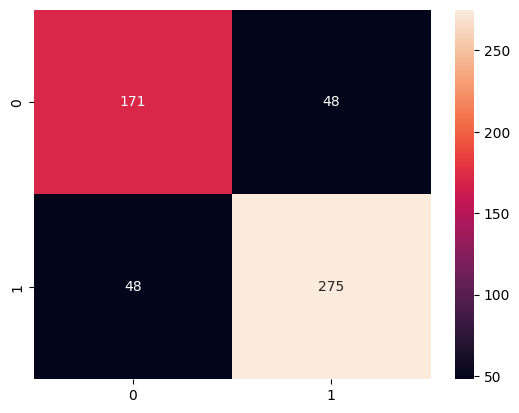

In [23]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g') # font size

In [24]:
# df_features_test = df_features.loc[y_test.index.tolist(), :]

# df_anl = pd.DataFrame({
#     "y_test": y_test.tolist(),
#     "y_pred": y_pred.tolist(),
#     "corpus_name": df_features.loc[y_test.index.tolist(), :]['corpus_name'].tolist(),  
# })

# for cp_nm in df_anl.corpus_name.unique():
    
#     print(f"""###############################################
# # corpus name: {cp_nm}
# ###############################################
#           """)
    
#     df_anl_cp = df_anl[df_anl.corpus_name == cp_nm]
    
#     print(classification_report(df_anl_cp.y_test, df_anl_cp.y_pred))
    
#     cm=confusion_matrix(df_anl_cp.y_test, df_anl_cp.y_pred)
#     sns.heatmap(cm, annot=True, fmt='g') # font size
#     plt.show()
    
# y_test_s = y_test.copy()
# y_test_s['corpus']

### Featue importance

In [25]:
# # Acessar o objeto RFE na pipeline
# rfe = pipeline.named_steps['selecting']
# # Acessar o array que indica quais características foram selecionadas
# selected_features_mask = rfe.support_

selected_features_mask = model.named_steps['selecting'].get_support()

# Usar o array para filtrar os nomes das colunas do DataFrame original
selected_features = X_train.columns[selected_features_mask].tolist()

print("Características selecionadas pelo RFE:")
print(selected_features)


Características selecionadas pelo RFE:
['parent_abordar', 'parent_acabar', 'parent_acender', 'parent_aclamar', 'parent_aconselhar', 'parent_acontecer', 'parent_adivinhar', 'parent_administrar', 'parent_admirar', 'parent_admitir', 'parent_adorar', 'parent_adormecer', 'parent_adotar', 'parent_adquirir', 'parent_agendar', 'parent_agir', 'parent_agitada', 'parent_agitar', 'parent_agradecer', 'parent_ajudar', 'parent_ajuntar', 'parent_alegar', 'parent_ameaçar', 'parent_andar', 'parent_ano', 'parent_anunciar', 'parent_apagar', 'parent_aparecer', 'parent_apoiar', 'parent_apostar', 'parent_aprovar', 'parent_aproveitar', 'parent_armar', 'parent_armazém', 'parent_arranjar', 'parent_ascender', 'parent_assustar', 'parent_atrair', 'parent_atrapalhar', 'parent_atravancar', 'parent_atravessar', 'parent_atribuir', 'parent_ação', 'parent_bastar', 'parent_be-located-at-91', 'parent_brincar', 'parent_buscar', 'parent_caber', 'parent_cair', 'parent_caixa', 'parent_calar', 'parent_calcular', 'parent_caminh

In [26]:
# Função para remover a parte após o último underscore
def remover_apos_ultimo_underscore(s):
    return "_".join(s.split("_")[:-1])

original_features = [remover_apos_ultimo_underscore(feat) for feat in selected_features]

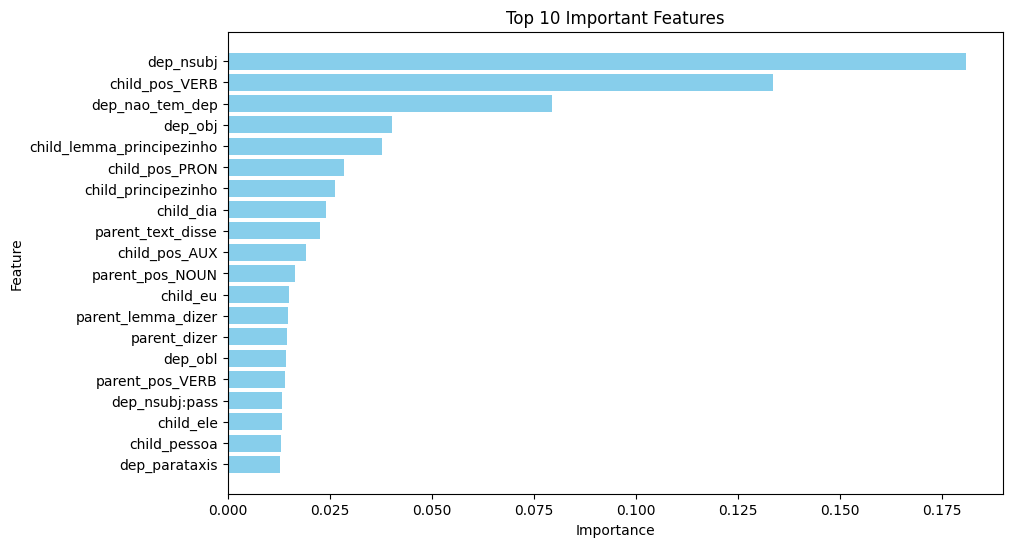

In [27]:
# Extrair o modelo XGBClassifier da pipeline
xgb_model = model.named_steps['estimator']

# Obter as importâncias das características
feature_importances = xgb_model.feature_importances_

# Criar um DataFrame para facilitar a manipulação e visualização
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    "original_feature": original_features,
    'importance': feature_importances
})

# Ordenar o DataFrame pelo valor de importância
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotar o gráfico de barras das principais características
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Inverter o eixo y para mostrar a característica mais importante no topo
plt.show()


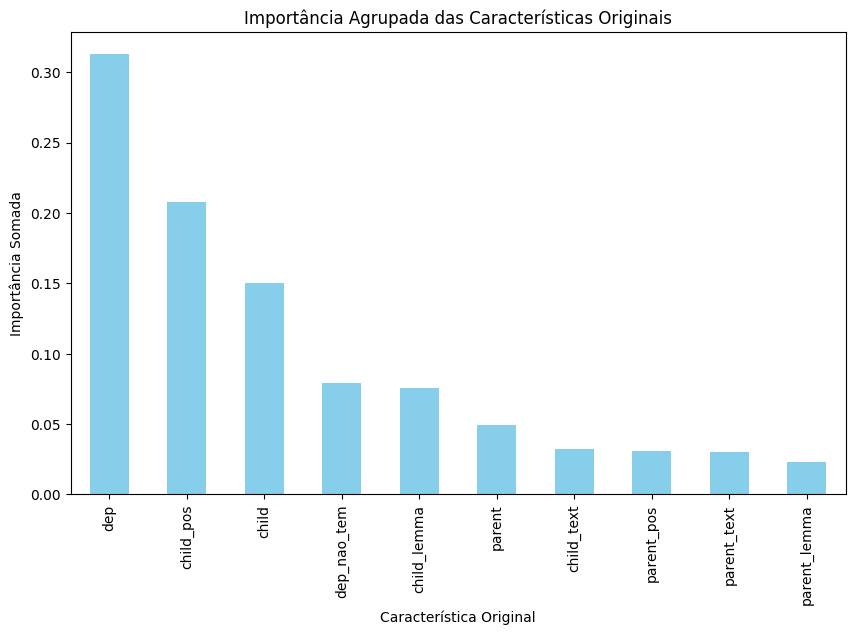

In [28]:
grouped_importances = feature_importance_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)
# Plotar o gráfico das características originais mais importantes
plt.figure(figsize=(10, 6))
grouped_importances.head(10).plot(kind='bar', color='skyblue')
plt.title('Importância Agrupada das Características Originais')
plt.xlabel('Característica Original')
plt.ylabel('Importância Somada')
plt.show()

### SHAP

In [29]:
# 1. Carregar o modelo treinado do pipeline
xgb_model = model.named_steps['estimator']

# 2. Criar o objeto Explainer para o modelo XGB
explainer = shap.TreeExplainer(xgb_model)

In [30]:

X_test_processed = X_test
for step in [step[0] for step in model.steps if step[0] != "estimator"]:
    
    print(step)
    
    if step == "sampling":
        pass
    else:
        X_test_processed = model[step].transform(X_test_processed)

scaling
sampling
selecting


In [31]:
# 3. Calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test_processed)

In [32]:
shap_values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
X_test_processed

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.33981904],
       [0.        , 0.        , 0.        , ..., 2.64068863, 0.        ,
        7.33981904],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.33981904],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.33981904],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.33981904],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        7.33981904]])

In [38]:
df_X_test_anl = pd.DataFrame(X_test_processed, columns = selected_features)

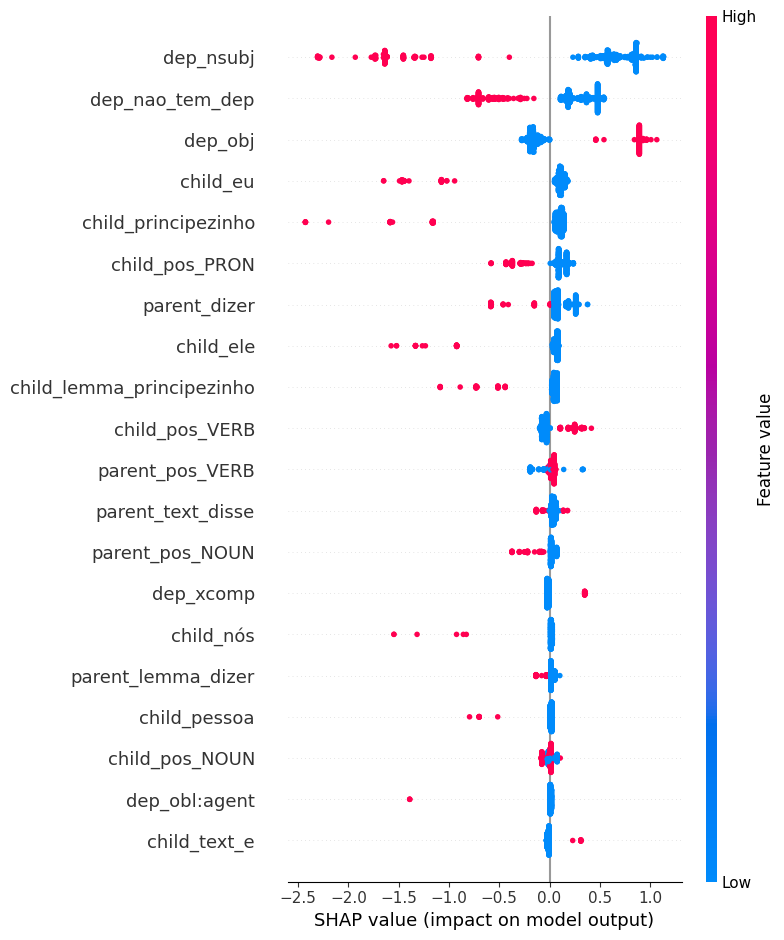

In [39]:
shap.summary_plot(shap_values, df_X_test_anl)
plt.show()

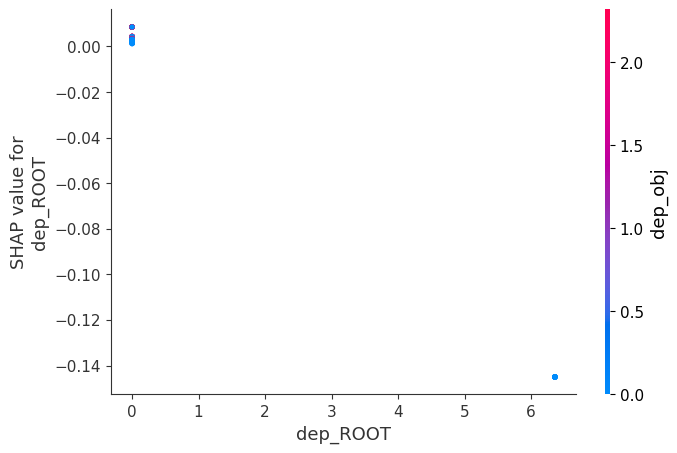

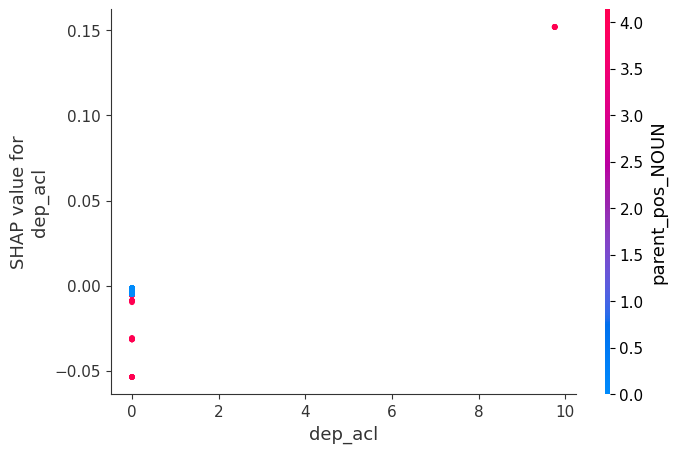

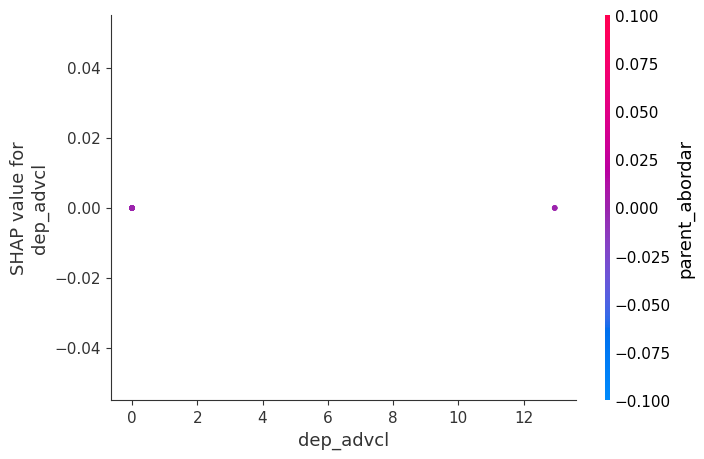

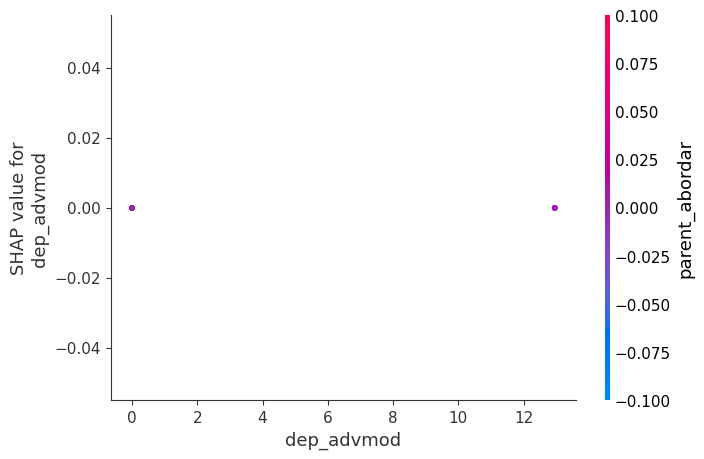

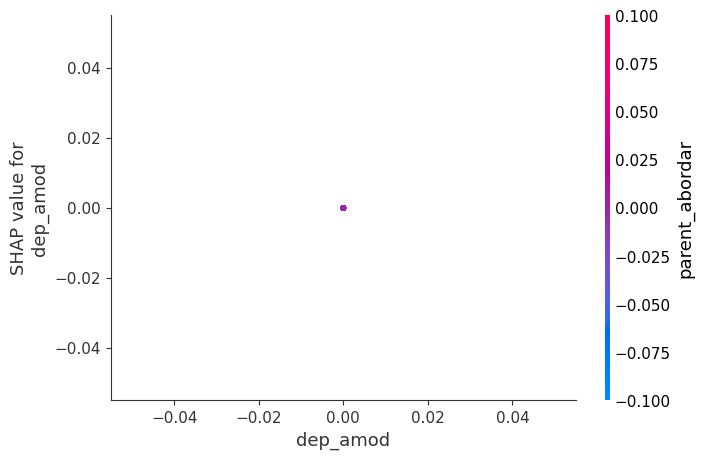

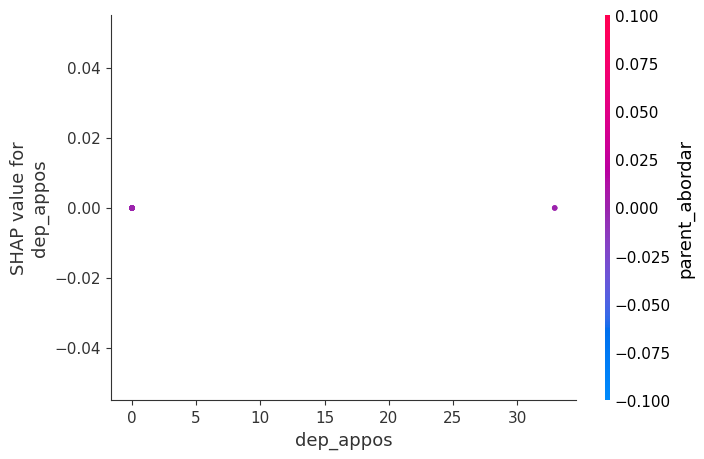

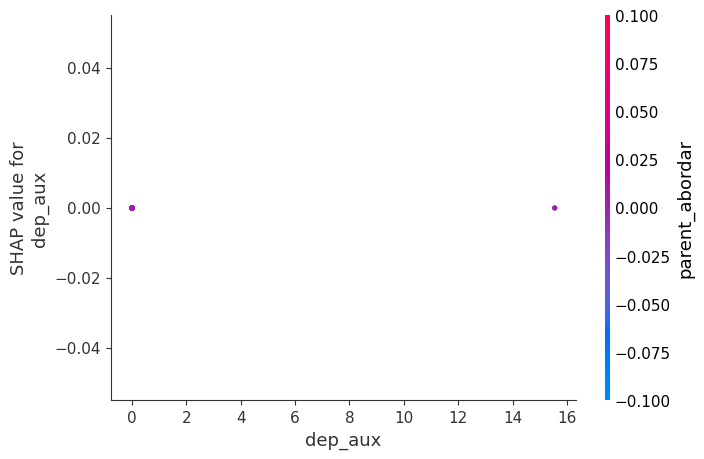

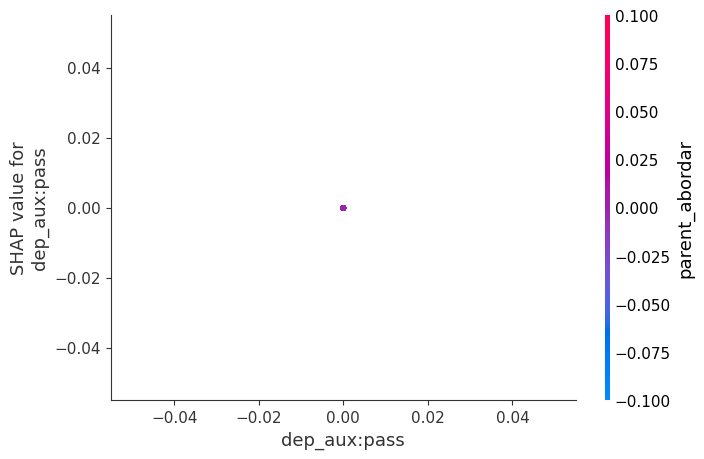

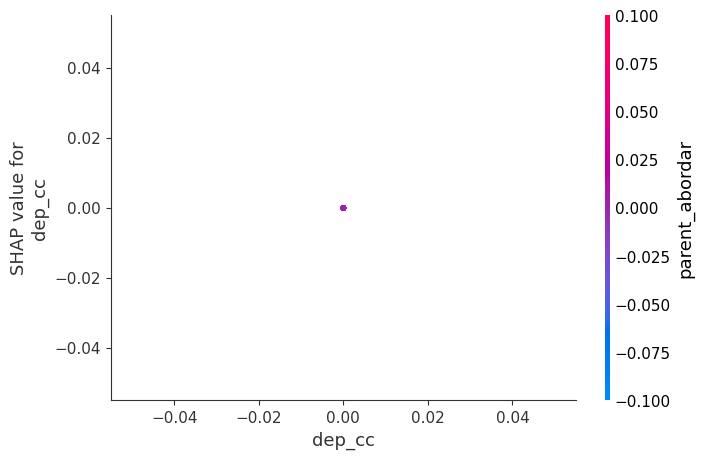

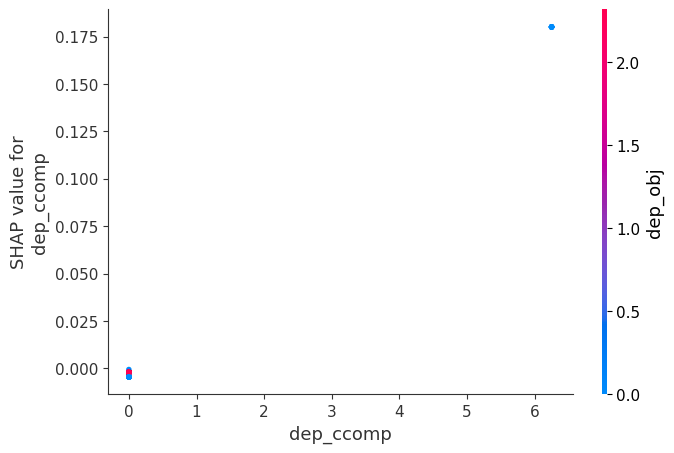

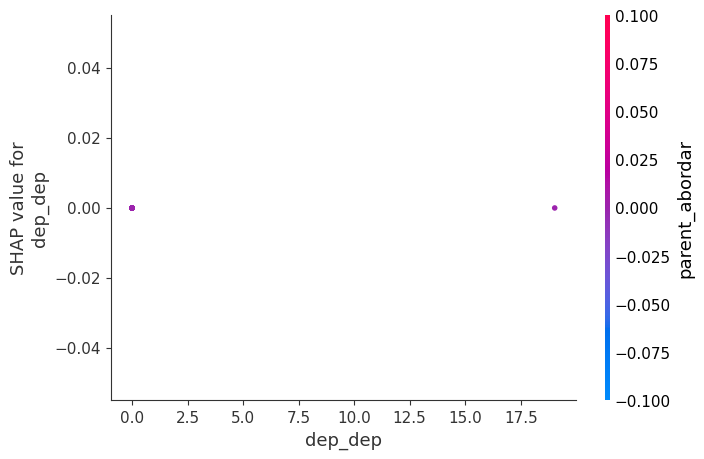

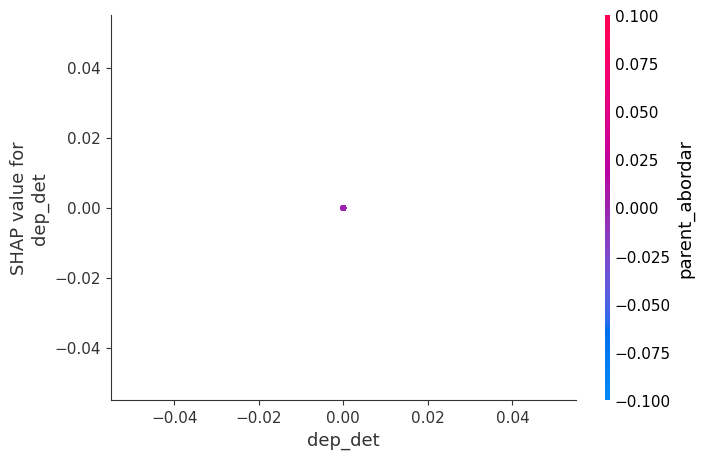

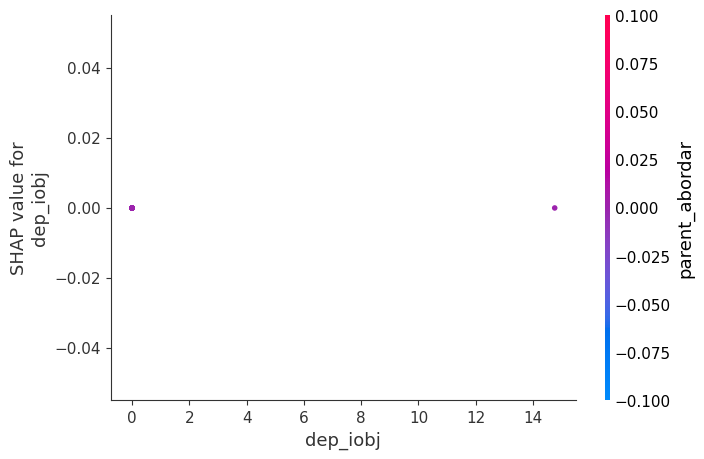

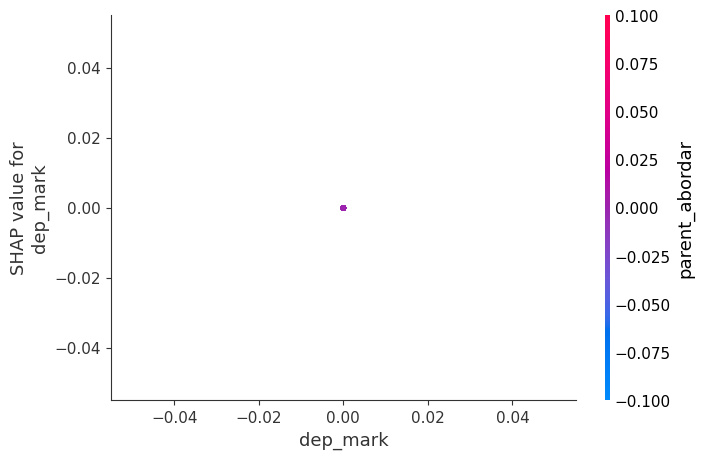

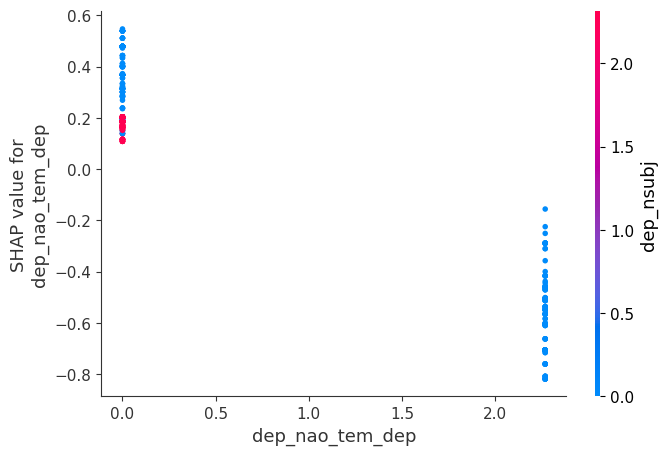

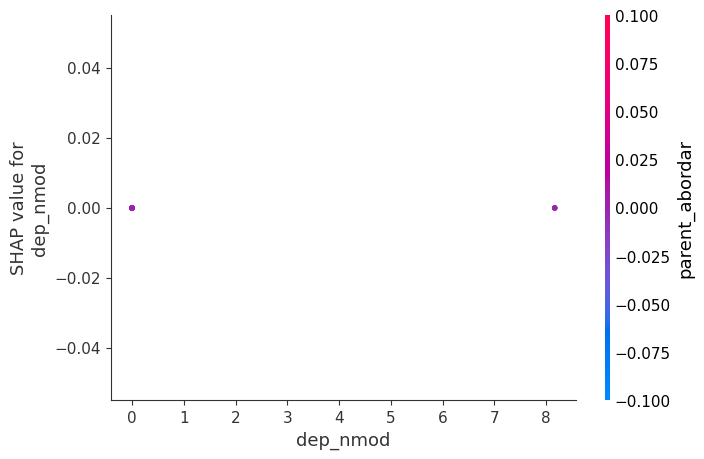

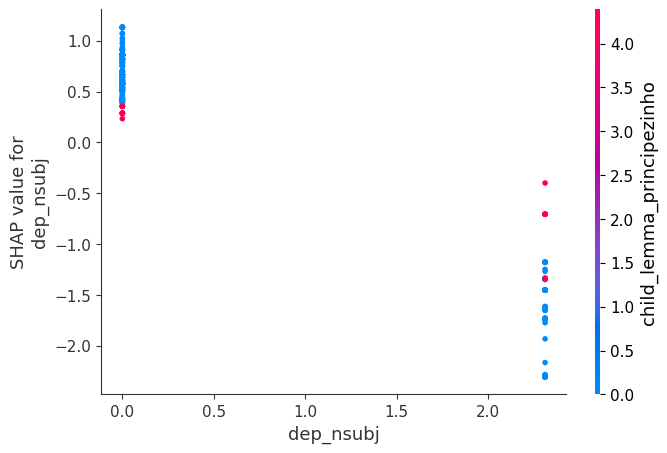

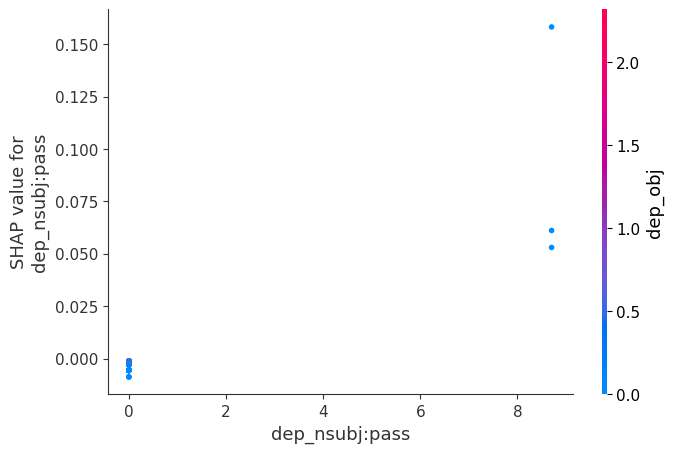

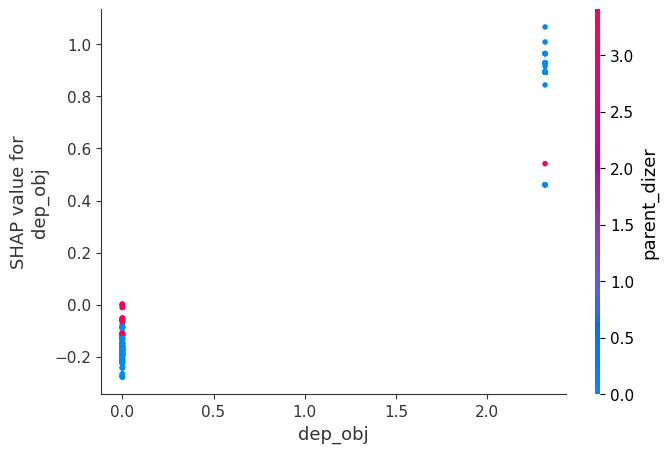

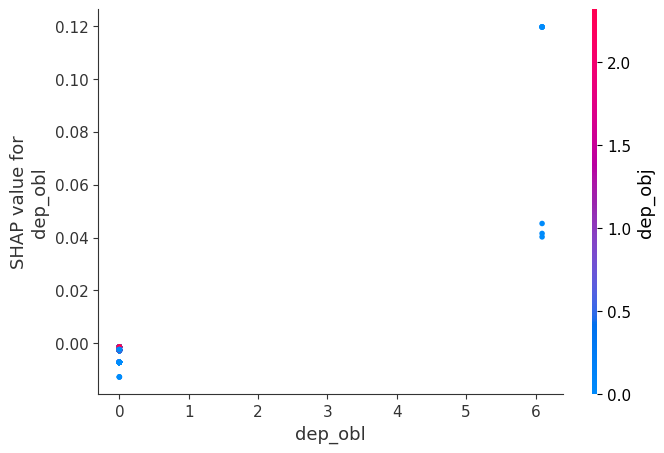

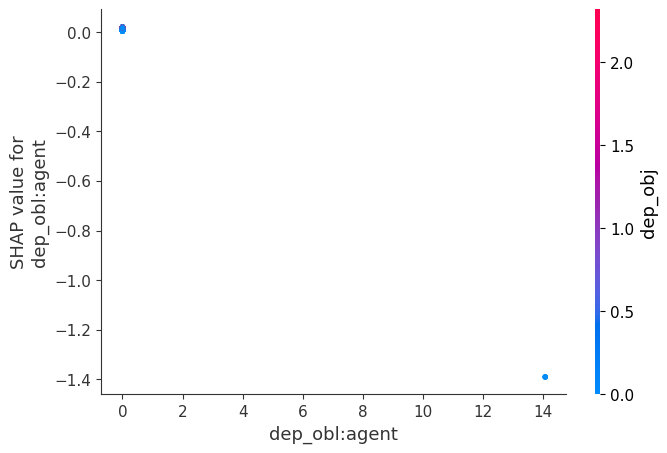

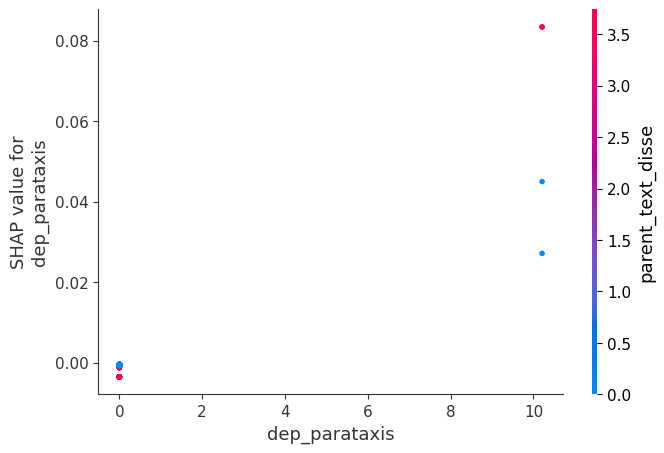

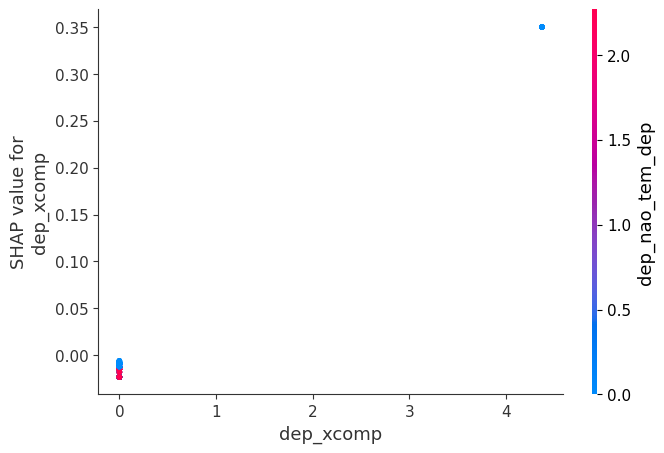

In [46]:
# Dependence Plot para cada feature
for feature in [col for col in df_X_test_anl.columns if "dep_" in col]:
    shap.dependence_plot(feature, shap_values, df_X_test_anl)
    plt.show()